# Emotion Recognition Model Training

This notebook trains an emotion recognition model by fine-tuning BERT. The `https://huggingface.co/datasets/dair-ai/emotion` dataset contains tweets labelled with 6 emotions: anger, fear, joy, love, sadness, and surprise. This dataset is split into training data and testing data to train and evaluate the model respectively.

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.0 MB/s eta 0:00:00


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.2 MB/s eta 0:00:00


In [133]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [72]:
# Initialise BERT tokenizer
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [73]:
# Method to encode text using BertTokenizer
def encode(corpus):
    encoded = tokeniser.batch_encode_plus(corpus, max_length=128,
                                         add_special_tokens=True,
                                         return_attention_mask=True,
                                         truncation=True,
                                         return_tensors='pt',
                                         padding='max_length')

    return encoded['input_ids'], encoded['attention_mask']

# Method to get the data loader for tokens
def get_dataloader(ids, masks, data, isRandom):
    tensored = TensorDataset(ids, masks, data)
    sampler = RandomSampler(tensored) if isRandom else SequentialSampler(tensored)
    dataloader = DataLoader(tensored, sampler=sampler, batch_size=16)
    return dataloader

In [74]:
# Load tweet dataset labelled with emotions
dataset = load_dataset('dair-ai/emotion', name='unsplit', split='train')

In [75]:
# Get unique emotion labels from data 
data_labels = dataset.features['label'].names
data_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [76]:
# Format the dataset
dataset.set_format(type='pandas')
N = len(set(dataset['label']))
all_data = dataset[:]

In [77]:
print(all_data)

                                                     text  label
0       i feel awful about it too because it s my job ...      0
1                                   im alone i feel awful      0
2       ive probably mentioned this before but i reall...      1
3                i was feeling a little low few days back      0
4       i beleive that i am much more sensitive to oth...      2
...                                                   ...    ...
416804  that was what i felt when i was finally accept...      1
416805  i take every day as it comes i m just focussin...      4
416806      i just suddenly feel that everything was fake      0
416807  im feeling more eager than ever to claw back w...      1
416808  i give you plenty of attention even when i fee...      0

[416809 rows x 2 columns]


In [78]:
# Large imbalances in the data can be seen here
for label in set(all_data.label):
    print (f"{label}: {len(all_data[all_data.label == label])}")

0: 121187
1: 141067
2: 34554
3: 57317
4: 47712
5: 14972


In [79]:
# Apply downsampling and select 5,000 from each sample to avoid any bias
final_data = all_data.groupby('label').apply(lambda x: x.sample(5000)).reset_index(drop=True)

In [80]:
# To save time when experimenting, use a smaller dataset
eval_data = all_data.groupby('label').apply(lambda x: x.sample(400)).reset_index(drop=True)

In [81]:
device = 'cuda'

# Split the data into training data for development and testing data for evaluation

In [84]:
# Split into training, testing and validation
x_train, x_test, y_train, y_test = train_test_split(eval_data['text'], eval_data['label'], test_size=0.15, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [85]:
# View how many data points we have
print(x_train.shape, x_test.shape, x_val.shape)

(1836,) (360,) (204,)


In [86]:
# Encode training and testing data
train_ids, train_masks = encode(list(x_train))
test_ids, test_masks = encode(list(x_test))
val_ids, val_masks = encode(list(x_val))

In [87]:
# Create tensors for use later
y_train = torch.LongTensor(list(y_train))
y_test = torch.LongTensor(list(y_test))
y_val = torch.LongTensor(list(y_val))

In [88]:
# Get dataloaders for training and testing data, shuffle the training data but not testing and val
train_loader = get_dataloader(train_ids, train_masks, y_train, True)
test_loader = get_dataloader(test_ids, test_masks, y_test, False)
val_loader = get_dataloader(val_ids, val_masks, y_val, False)

# Functions to set up and train a model

In [89]:
# Setup function to create a new model
def make_classifier():
  classifier =  BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                          num_labels=N,
                                                          output_attentions=False,
                                                          output_hidden_states=False)
  classifier = classifier.cuda()
  return classifier

In [90]:
# Method to save a model
def save_model(model, path):
    torch.save(model, path)

In [91]:
# Code to create optimiser and scheduler
def create_optimiser(classifier, learning_rate):
  return AdamW(classifier.parameters(), lr=learning_rate)

def create_scheduler(optimiser, epochs):
  return get_linear_schedule_with_warmup(optimiser,
                                  num_training_steps=len(train_loader) * epochs,
                                  num_warmup_steps=0)

In [92]:
# Code to train model
def run_training_loop(classifier, optimiser, scheduler, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(30):
      classifier.train()
      train_loss = 0
      
      # Run a loop over the training data
      for step, data in enumerate(tqdm(train_loader, desc='Training')):
          ids, masks, labels = [x.to(device) for x in data]
          output = classifier(input_ids=ids, attention_mask=masks, labels=labels)
          loss = output.loss
          train_loss += loss.item()
          
          # Parameter update based on loss
          classifier.zero_grad()
          loss.backward()
          del loss
          
          clip_grad_norm_(parameters=classifier.parameters(), max_norm=1.0)
          optimiser.step()
          scheduler.step()
        
      
      train_losses.append(train_loss / (step + 1))
      print("Loss: {}".format(train_loss / (step + 1)))
      if ((epoch + 1) in epochs):
        val_loss = test_on_val_set(classifier)
        val_losses.append(val_loss)
  
  return train_losses, val_losses
      
  

In [93]:
def test_on_val_set(classifier):
  val_loss = 0

  with torch.no_grad():
      for data in tqdm(val_loader):
          ids, mask, labels = [x.to(device) for x in data]
          output = classifier(input_ids=ids, attention_mask=mask, labels=labels)

          loss = output.loss
          val_loss += loss.item()
          
  print(f"Val loss: {val_loss}")
  return val_loss

# Run Experiment to select hyperparameters

In [98]:
# We are interested in learning rate and epochs, so perform grid search
# lrs = [1e-3, 1e-4, 1e-5]
# No convergence seen with lr 1e-3 so discount it
lrs = [1e-4, 1e-5]
epochs = [10, 20, 30]

In [99]:
# Run an experiment to test out different learning rate / epoch performance
def run_experiment():
  all_val_losses = []
  for rate in lrs:
    classifier = make_classifier()
    optimiser = create_optimiser(classifier, rate)
    scheduler = create_scheduler(optimiser, 30)
    cur_train_losses, val_losses = run_training_loop(classifier, optimiser, scheduler, epochs)
    all_val_losses.append(val_losses)
  
  return all_val_losses

In [100]:
run_experiment()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 1.123774300450864


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.37019056271275746


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.24230499169586794


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.1871378350921947


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.1249841284148557


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0839332033596609


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.029473559002634948


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.028355386942807263


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.025941108378490594


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.007460954853677718


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 10.853477928438224


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.022886546694359782


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.015080993666323712


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0020004441663015473


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.001800875784196567


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0018516766471768041


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0015802585171869673


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.009564045715176136


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.005610405070120064


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0021891143412136917


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0011569045313239179


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 12.16139925243624


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0014033330810058902


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.001324265290800806


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0007989101968553809


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0012320576329290381


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0009901371329602705


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0011561187895890528


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0033734623715408023


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0009962112666866945


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0009599268321914639


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0011184891938920253


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 13.55860388468136


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 1.7838193934896718


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 1.510754914905714


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 1.0468479586684185


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.6521109104156494


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.40513555122458417


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.24587610836910165


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.14987868838336157


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.09881256922431614


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.06844704458085091


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.04108344999182483


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 5.388790194876492


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.029318618644838746


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.01825673204401265


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.010871112075350855


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0119986392841067


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.009071239381623656


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.010036623597388035


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.00512545779246189


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.007629678122010892


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.004825625025019374


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0034196421392666903


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 6.288000836037099


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.007964319569747086


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.003106595397643421


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.006722074880710115


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.005366204619286177


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.005303624561866341


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0036458857651071055


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.007809855526252447


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0015500406962414474


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.0032377060634367493


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Loss: 0.001836534658872077


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 6.17595883004833


[[10.853477928438224, 12.16139925243624, 13.55860388468136],
 [5.388790194876492, 6.288000836037099, 6.17595883004833]]

In [102]:
# Numbers taken from best experiment
5.38879 / 204

0.026415637254901963

From the experiment, the best performing set of parameters was seen at 10 epochs with a 1e-5 lr. This resulted in a loss of 0.0264 on the validation set

# Train final model

In [103]:
# Get BERT sequence classifier
classifier = make_classifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Generate new data split on larger dataset

In [106]:
# Split into training, testing and val
x_train, x_test, y_train, y_test = train_test_split(final_data['text'], final_data['label'], test_size=0.15, random_state=1)

In [107]:
# View how many data points we have
print(x_train.shape, x_test.shape, x_val.shape)

(25500,) (4500,) (204,)


In [108]:
# Encode training and testing data
train_ids, train_masks = encode(list(x_train))
test_ids, test_masks = encode(list(x_test))

In [109]:
# Create tensors for use later
y_train = torch.LongTensor(list(y_train))
y_test = torch.LongTensor(list(y_test))

In [110]:
# Get dataloaders for training and testing data, shuffle the training data but not testing
train_loader = get_dataloader(train_ids, train_masks, y_train, True)
test_loader = get_dataloader(test_ids, test_masks, y_test, False)

In [111]:
# Parameters to control the model
lr = 1e-5
epochs = 10

In [112]:
# Add AdamW optimizer and create scheduler
optimiser = create_optimiser(classifier, lr)
scheduler = create_scheduler(optimiser, epochs)

Train the model

In [114]:
# Training loop for final model
train_losses = []

for epoch in range(epochs):
    classifier.train()
    train_loss = 0
    
    for step, data in enumerate(tqdm(train_loader, desc='Training')):
        ids, masks, labels = [x.to(device) for x in data]
        output = classifier(input_ids=ids, attention_mask=masks, labels=labels)
        loss = output.loss
        train_loss += loss.item()
        
        classifier.zero_grad()
        loss.backward()
        del loss
        
        clip_grad_norm_(parameters=classifier.parameters(), max_norm=1.0)
        optimiser.step()
        scheduler.step()
    
    # Intermediary saving
    if epoch % 5 == 0:
        save_model(classifier, './secondtry' + str(epoch))
    train_losses.append(train_loss / (step + 1))
    print("Loss: {}".format(train_loss / (step + 1)))
      

Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.5230556914899521


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.16268511773163039


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.12152263637037056


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.10863411698703347


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.09800500785878631


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.08474240149583123


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.0779025751524859


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.06827563136953546


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.06066643999741564


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Loss: 0.05039440063577503


In [115]:
# Evaluate the classifier
classifier.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Save the model

In [122]:
torch.save(classifier.state_dict(), 'drive/MyDrive/NLUColabFiles/finallargedict')

In [125]:
# Load classifier
classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                          num_labels=6,
                                                          output_attentions=False,

                                                          output_hidden_states=False)
classifier.load_state_dict(torch.load('drive/MyDrive/NLUColabFiles/finallargedict'))
classifier.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Evaluation

Evaluate the precision, recall and f1 score for each of the 6 emotions, which are used to analyse performance. We also plot a confusion matrix of the predicted classes.

In [126]:
# Testing
test_pred = []
test_loss = 0

with torch.no_grad():
    for data in tqdm(test_loader):
        ids, mask, labels = [x.to(device) for x in data]
        output = classifier(input_ids=ids, attention_mask=mask, labels=labels)

        loss = output.loss
        test_loss += loss.item()
        
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)


  0%|          | 0/282 [00:00<?, ?it/s]

In [127]:
print(classification_report(test_pred, list(y_test),target_names=data_labels))

              precision    recall  f1-score   support

     sadness       0.95      0.96      0.96       736
         joy       0.90      0.97      0.94       706
        love       0.98      0.93      0.95       804
       anger       0.96      0.94      0.95       766
        fear       0.87      0.92      0.90       725
    surprise       0.97      0.91      0.94       763

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500



[Text(0, 0.5, 'sadness'),
 Text(0, 1.5, 'joy'),
 Text(0, 2.5, 'love'),
 Text(0, 3.5, 'anger'),
 Text(0, 4.5, 'fear'),
 Text(0, 5.5, 'surprise')]

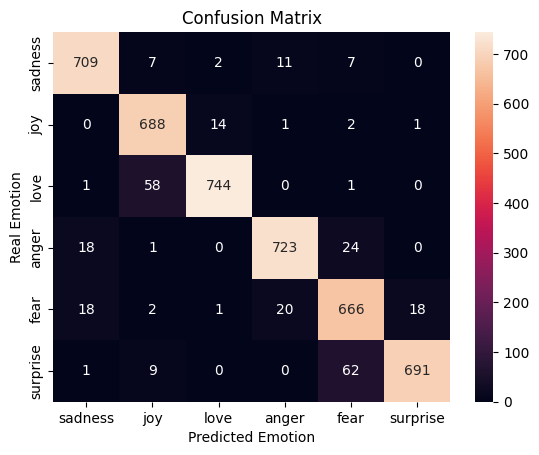

In [135]:
matrix = confusion_matrix(test_pred, list(y_test))

ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted Emotion')
ax.set_ylabel('Real Emotion')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(data_labels)
ax.yaxis.set_ticklabels(data_labels)